In [1]:
import os
import pickle
import plotting
import custom_tools
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import pearsonr
from dataset import TissueDataset
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


dataset_name = "JacksonFischer"
RAW_DATA_PATH = os.path.join("../data", f"{dataset_name}/raw")
dataset = TissueDataset(os.path.join(f"../data/{dataset_name}", "month"),  "month")

adata_exp = sc.read_h5ad(f"../data/out_data/adatafiles/JacksonFischer/JacksonFischer_JF_concatenated_explanations.h5ad")
adata_exp.obs_names_make_unique()

/home/rifaioglu/miniconda3/envs/py_gem/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


Target prediction: OSmonth


/home/rifaioglu/miniconda3/envs/py_gem/lib/python3.11/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [2]:
imp_threshold = 0.75
# Get the importance of the nodes
node_importance = np.array(adata_exp.obs["importance"])
node_imp_thr = np.quantile(node_importance, imp_threshold)

importances_hard_v2 = np.array(node_importance > node_imp_thr, dtype="str")
# print("importances_hard", importances_hard)
importances_hard_v2 = pd.Series(importances_hard_v2, dtype="category")
# print(importances_hard)
adata_exp.obs["importance_hard"] = importances_hard_v2.values

<h1>  Generation of Samples Important Regions </h1>  

 18%|█▊        | 203/1114 [00:03<00:13, 69.09it/s]

Pearson correlation: 0.5721228615179502, p-value: 5.082871614159471e-46
372lr


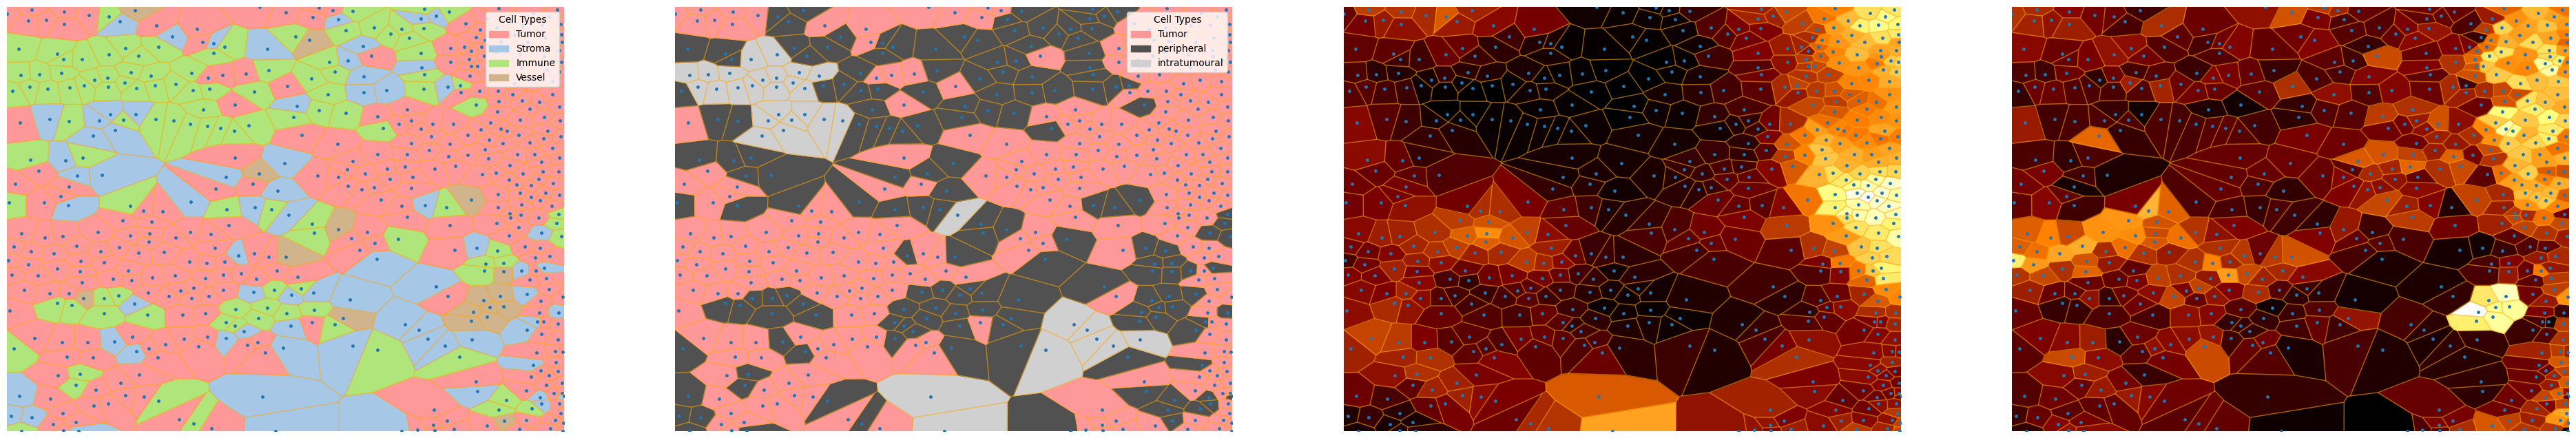

 31%|███       | 343/1114 [00:06<00:11, 66.80it/s]

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
count=0
df_list = []
for test_graph in tqdm(dataset):
    gene_list = custom_tools.get_gene_list()
    with open(os.path.join(RAW_DATA_PATH, f'{test_graph.img_id}_{test_graph.p_id}_coordinates.pickle'), 'rb') as handle:
                coordinates_arr = pickle.load(handle)
    tmp_adata_exp = adata_exp[adata_exp.obs.img_id==test_graph.img_id,:]
    
    # Convert coordinates array to a dataframe
    coords_df = pd.DataFrame(coordinates_arr, columns=['X', 'Y'])
    # print(coords_df.shape)
    df = tmp_adata_exp.obs.copy()
    
    # Convert array to DataFrame
    new_columns = pd.DataFrame(test_graph.x, columns=gene_list)
    
    # Reset both indices to avoid index alignment issues
    df = df.reset_index(drop=True)
    new_columns = new_columns.reset_index(drop=True)

    # Concatenate without considering index values
    df = pd.concat([df, new_columns], axis=1)
    # print(df.shape)
    # add coordinates
    df = pd.concat([df, coords_df], axis=1)
    
    
    from scipy.spatial.distance import cdist

    # Assuming df has columns 'x', 'y' for region coordinates
    tumor_centroids = df[df["class"] == "Tumor"][["X", "Y"]].values
    stromal_immune_points = df[df["class"].isin(["Vessel", "Stroma", "Immune"])][["X", "Y"]].values

    # Compute minimum distance from each stromal/immune point to tumor points
    distances = cdist(stromal_immune_points, tumor_centroids, metric='euclidean')
    min_distances = distances.min(axis=1)
    # print(min_distances.shape)

    # Define a threshold (e.g., 50 pixels) to classify as peripheral
    df.loc[df["class"].isin(["Vessel", "Stroma", "Immune"]), "region_type"] = ["peripheral" if d < 30 else "intratumoural" for d in min_distances]
    test_graph.region_type = df["region_type"].values
    """import seaborn as sns
    import matplotlib.pyplot as plt

    sns.boxplot(data=df, x="region_type", y="importance")
    plt.title("Importance in Intratumoural vs. Peripheral Regions")
    plt.show()"""
    
    # Subset only important regions
    important_df = df[df["importance_hard"] == "True"]
    # Compute the fraction of important regions that are Tumor
    tumor_fraction_in_important = (important_df["class"] == "Tumor").mean()
    
    marker =  "panCK"
    marker =  "c-Myc"
    tissue_region = "tumor"
    df_list.append(df)
    # print(f"Fraction of important regions that are Tumor: {tumor_fraction_in_important:.2f}")
    
    if tumor_fraction_in_important>0.7:
        node_to_score_dict = dict()
        node_to_imp_dict = dict()
        node_to_gene_dict = dict()
        node_to_region_dict = dict()
        
        for node_idx, row in df.iterrows():
            # node_idx =  int(ind.split("-")[0])
            node_to_score_dict[node_idx] = row.importance
            node_to_gene_dict[node_idx]  = row[marker]
            node_to_imp_dict[node_idx] = 1 if row.importance_hard=="True" else 0
            node_to_region_dict[node_idx] = row.region_type
        # Compute Pearson correlation
        corr, p_value = pearsonr(df["importance"], df[marker])
        
        if corr >0.5:
            print(f"Pearson correlation: {corr}, p-value: {p_value}")
            img_id = test_graph.img_id
            print(img_id)
            plot = True
            if plot:
                plt.rcParams['figure.figsize'] = 48, 8
                fig, axs = plt.subplots(1, 4)
                
                # Define a custom pastel colormap
                colors = ["#FF9999", "#A7C7E7", "#B0E57C", "#D2B48C"]  # Pastel Red, Blue, Green, Orange
                cmap = LinearSegmentedColormap.from_list("custom_pastel", colors, N=256)
                plotting.plot_node_types_voronoi(test_graph, coordinates_arr, axs[0], node_type="ct_class", cmap =cmap,  ct_order= ["Tumor", "Stroma", "Immune", "Vessel"])
                colors = ["#FF9999", "#505050", "#D0D0D0"]  # Very dark grey, grey, light grey
                cmap = LinearSegmentedColormap.from_list("custom_grey", colors, N=256)
                plotting.plot_node_types_voronoi(test_graph, coordinates_arr, axs[1], node_type="region_type", cmap =cmap, ct_order= ["Tumor", "peripheral", "intratumoural"])
                plotting.plot_node_importances_voronoi(test_graph, coordinates_arr, node_to_score_dict, axs[2])
                plotting.plot_node_importances_voronoi(test_graph, coordinates_arr, node_to_gene_dict,  axs[3])
                
                
                """plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/{test_graph.img_id}_{tissue_region}.pdf", dpi=300)
                plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/{test_graph.img_id}_{tissue_region}.png", dpi=300)"""
                plt.show()
                plt.clf()
        
        

    """count +=1
    if count==20:
        break"""
        
df_concat = pd.concat(df_list, ignore_index=True)         


In [ ]:
"""from scipy.stats import ttest_ind
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Perform the T-test
    intratumoural_importance = df_concat[df_concat["region_type"] == "intratumoural"]["importance"]
    peripheral_importance = df_concat[df_concat["region_type"] == "peripheral"]["importance"]

    t_stat, p_val = ttest_ind(intratumoural_importance, peripheral_importance)
    print(f"T-test p-value: {p_val:.4f}")

    # Define custom colors
    custom_palette = {"intratumoural": "#505050", "peripheral": "#D0D0D0"}

    # Create the boxplot
    plt.figure(figsize=(1, 3))
    ax = sns.boxplot(data=df_concat, x="region_type", y="importance", width=0.6, showfliers=False, palette=custom_palette)

    # Add significance annotation
    x1, x2 = 0, 1  # Positions of the two groups on the x-axis
    y_max = df_concat["importance"].max()  # Find max y-value for positioning
    y_max = 0.30  # Find max y-value for positioning
    y_offset = (y_max * 0.05)  # Small offset above max value

    # Draw a line for the significance annotation
    plt.plot([x1, x1, x2, x2], [y_max + y_offset, y_max + 2*y_offset, y_max + 2*y_offset, y_max + y_offset], color="black")

    # Display p-value
    p_text = f"p = {p_val:.3e}" if p_val < 0.001 else f"p = {p_val:.3f}"
    plt.text((x1 + x2) / 2, y_max + 2.5 * y_offset, p_text, ha="center", fontsize=12, fontweight="bold")

    # Formatting
    plt.title("Importance in Intratumoural vs. Peripheral Regions")
    plt.xlabel("Region Type")
    plt.ylabel("Importance")
    plt.show()
"""

region_type
peripheral       70.562422
intratumoural    29.437578
Name: proportion, dtype: float64


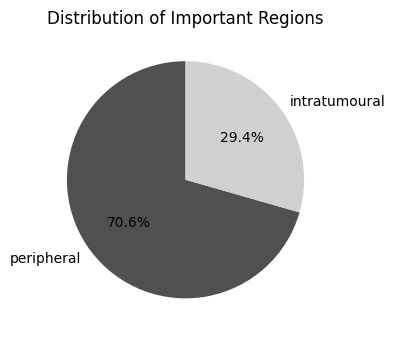

Binomial Test p-value: 0.0000


/tmp/ipykernel_3118079/345357033.py:29: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_val = binom_test(n_intratumoural, n_intratumoural + n_peripheral, p=0.5, alternative="two-sided")


In [ ]:
# Filter only important regions
df_important = df_concat[df_concat["importance_hard"] == "True"]

# Count occurrences of region types
region_counts = df_important["region_type"].value_counts(normalize=True) * 100

# Display results
print(region_counts)


import matplotlib.pyplot as plt


plt.figure(figsize=(4, 4))
colors = ["#505050", "#D0D0D0"]  # Matching your boxplot colors
plt.pie(region_counts, labels=region_counts.index, autopct="%1.1f%%", colors=colors, startangle=90)
plt.title("Distribution of Important Regions")
plt.tight_layout()
plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/peripheral_vs_intratumoural.pdf", dpi=300)
plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/peripheral_vs_intratumoural.png", dpi=300)
plt.show()

from scipy.stats import binom_test


n_intratumoural = (df_important["region_type"] == "intratumoural").sum()
n_peripheral = (df_important["region_type"] == "peripheral").sum()

# Perform binomial test (expected proportion = 0.5)
p_val = binom_test(n_intratumoural, n_intratumoural + n_peripheral, p=0.5, alternative="two-sided")

print(f"Binomial Test p-value: {p_val:.4f}")






In [8]:
df.columns

Index(['clinical_type', 'img_id', 'p_id', 'tumor_grade', 'osmonth',
       'importance', 'importance_hard', 'cell_type', 'class', 'H3K27me3',
       'CK5', 'Fibronectin', 'CK19', 'CK8/18', 'Twist', 'CD68', 'CK14', 'SMA',
       'Vimentin', 'c-Myc', 'HER2', 'CD3', 'pHH3', 'Slug', 'ER', 'PR', 'p53',
       'CD44', 'CD45', 'GATA3', 'CD20', 'CAIX', 'E/P-cadherin', 'Ki-67',
       'EGFR', 'pS6', 'vWF/CD31', 'pmTOR', 'CK7', 'panCK', 'CC3/cPARP', 'HH3',
       'X', 'Y', 'region_type'],
      dtype='object')

In [ ]:
df_concat["region_type"]

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
count=0
for test_graph in tqdm(dataset):
    gene_list = custom_tools.get_gene_list()
    with open(os.path.join(RAW_DATA_PATH, f'{test_graph.img_id}_{test_graph.p_id}_coordinates.pickle'), 'rb') as handle:
                coordinates_arr = pickle.load(handle)
    tmp_adata_exp = adata_exp[adata_exp.obs.img_id==test_graph.img_id,:]
    
    df = tmp_adata_exp.obs.copy()
    print(test_graph)
    # Convert array to DataFrame
    new_columns = pd.DataFrame(test_graph.x, columns=gene_list)
    
    # Reset both indices to avoid index alignment issues
    df = df.reset_index(drop=True)
    new_columns = new_columns.reset_index(drop=True)

    # Concatenate without considering index values
    df = pd.concat([df, new_columns], axis=1)
    
    

    # Subset only important regions
    important_df = df[df["importance_hard"] == "True"]
    # Compute the fraction of important regions that are Tumor
    tumor_fraction_in_important = (important_df["class"] == "Immune").mean()

    # print(f"Fraction of important regions that are Tumor: {tumor_fraction_in_important:.2f}")
    marker_protein = "CD3"
    if tumor_fraction_in_important>0.7:
        node_to_score_dict = dict()
        node_to_imp_dict = dict()
        node_to_gene_dict = dict()
        
        for node_idx, row in df.iterrows():
            # node_idx =  int(ind.split("-")[0])
            node_to_score_dict[node_idx] = row.importance
            node_to_gene_dict[node_idx]  = row[marker_protein]
            node_to_imp_dict[node_idx] = 1 if row.importance_hard=="True" else 0
        # Compute Pearson correlation
        corr, p_value = pearsonr(df["importance"], df[marker_protein])
        
        # if corr >0.5:
        print(f"Pearson correlation: {corr}, p-value: {p_value}")
        img_id = test_graph.img_id
        print(img_id)
        plt.rcParams['figure.figsize'] = 48, 8
        fig, axs = plt.subplots(1, 4)
        # plotting.plot_graph(test_graph, coordinates_arr, axs[0], font_size=5,  node_size=100, width=1)
        plotting.plot_node_importances_voronoi(test_graph, coordinates_arr, node_to_imp_dict,  axs[0], cmap=plt.cm.afmhot_r)
        # plotting.plot_node_importances(test_graph, coordinates_arr, node_to_score_dict,  axs[2], node_size=100, width=1)
        plotting.plot_node_importances_voronoi(test_graph, coordinates_arr, node_to_score_dict, axs[1])
        plotting.plot_node_importances_voronoi(test_graph, coordinates_arr, node_to_gene_dict, axs[2])
        plotting.plot_node_types_voronoi(test_graph, coordinates_arr, axs[3])
        plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/{test_graph.img_id}.pdf")
        plt.savefig(f"/home/rifaioglu/projects/GNNClinicalOutcomePrediction/plots/explanations/JacksonFischer/{test_graph.img_id}.png")
        plt.show()
        plt.clf()
        
        

    """count +=1
    if count==500:
        break"""
    

<h1> Important regions periphrael   </h1>

In [7]:
import pandas as pd

count=0
for test_graph in tqdm(dataset):
    gene_list = custom_tools.get_gene_list()
    with open(os.path.join(RAW_DATA_PATH, f'{test_graph.img_id}_{test_graph.p_id}_coordinates.pickle'), 'rb') as handle:
                coordinates_arr = pickle.load(handle)
    tmp_adata_exp = adata_exp[adata_exp.obs.img_id==test_graph.img_id,:]
    
    # Convert coordinates array to a dataframe
    coords_df = pd.DataFrame(coordinates_arr, columns=['X', 'Y'])
    df = tmp_adata_exp.obs.copy()
    
    # Convert array to DataFrame
    new_columns = pd.DataFrame(test_graph.x, columns=gene_list)
    
    # Reset both indices to avoid index alignment issues
    df = df.reset_index(drop=True)
    new_columns = new_columns.reset_index(drop=True)

    # Concatenate without considering index values
    df = pd.concat([df, new_columns], axis=1)
    # add coordinates
    df = pd.concat([df, coords_df], axis=1)
    
    from scipy.spatial.distance import cdist

    # Assuming df has columns 'x', 'y' for region coordinates
    tumor_centroids = df[df["class"] == "Tumor"][["X", "Y"]].values
    stromal_immune_points = df[df["class"].isin(["Stroma", "Immune"])][["X", "Y"]].values

    # Compute minimum distance from each stromal/immune point to tumor points
    distances = cdist(stromal_immune_points, tumor_centroids, metric='euclidean')
    min_distances = distances.min(axis=1)
    # print(min_distances.shape)

    # Define a threshold (e.g., 50 pixels) to classify as peripheral
    df.loc[df["class"].isin(["Stroma", "Immune"]), "region_type"] = ["peripheral" if d < 50 else "intratumoural" for d in min_distances]
    
    """;"""


    
    

100%|██████████| 1114/1114 [00:09<00:00, 120.54it/s]


KeyError: 'intratumoural'

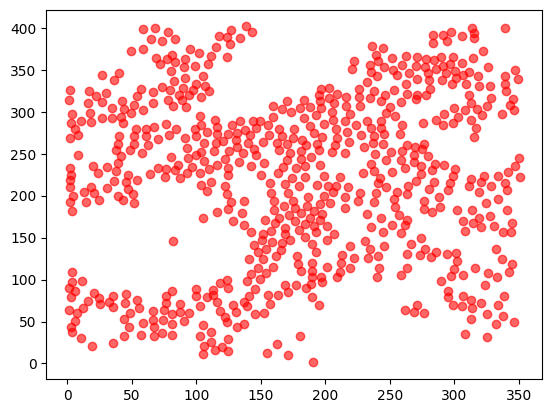

In [8]:
import matplotlib.pyplot as plt

# Define colors for different regions
colors = {
    "Tumor": "red",
    "Intratumoural": "blue",
    "Peripheral": "green"
}

# Plot tumor cells
tumor_cells = df[df["class"] == "Tumor"]
plt.scatter(tumor_cells["X"], tumor_cells["Y"], color="red", label="Tumor", alpha=0.6)

# Plot stromal/immune cells classified as peripheral or intratumoural
for region in ["intratumoural", "peripheral"]:
    subset = df[df["region_type"] == region]
    plt.scatter(subset["X"], subset["Y"], color=colors[region], label=region.capitalize(), alpha=0.6)

# Formatting
plt.xlabel("X Coordinate (µm)")
plt.ylabel("Y Coordinate (µm)")
plt.title("Spatial Distribution of Tumor and Peripheral Regions")
plt.legend()
plt.show()

In [9]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd


# Get tumor and stromal/immune coordinates
tumor_coords = df[df["class"] == "Tumor"][["X", "Y"]].values
stromal_immune_coords = df[df["class"].isin(["Stroma", "Immune"])][["X", "Y"]].values

# Fit k-NN model on tumor cells
knn = NearestNeighbors(n_neighbors=5, metric="euclidean")  # 5 nearest neighbors
knn.fit(tumor_coords)

# Find nearest tumor neighbors for each stromal/immune cell
distances, indices = knn.kneighbors(stromal_immune_coords)

# Classify cells based on the proximity of nearest neighbors
df.loc[df["class"].isin(["Stroma", "Immune"]), "region_type"] = [
    "intratumoural" if d.mean() < 50 else "peripheral" for d in distances  # Adjust threshold as needed
]

print(df)


    clinical_type img_id       p_id  tumor_grade  osmonth  importance  \
0        HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.121187   
1        HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.116591   
2        HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.154375   
3        HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.158961   
4        HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.161679   
..            ...    ...        ...          ...      ...         ...   
943      HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.148381   
944      HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.101997   
945      HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.085746   
946      HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.173569   
947      HR+HER2-  313ll  222-basel  tensor([2])     58.0    0.108172   

    importance_hard        cell_type   class  H3K27me3  ...       pS6  \
0             False  Small elongated  Stroma  0.42